**In this kernel I have designed basic recommendation system using both content based and collaborative approaches**.

### Importing dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_distances
import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

['ml-100k']


### Importing user data

In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

user_feats = pd.read_csv('../input/ml-100k/u.user', sep ='|', encoding ='latin-1',parse_dates = True,names=u_cols)
user_feats.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Importing ratings data

In [3]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv('../input/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Importing movie data

In [4]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_feats = pd.read_csv('../input/ml-100k/u.item', sep='|', names=m_cols,encoding='latin-1')
movie_feats.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Brief User Data Analysis 

In [5]:
# Total number of unique users and movies
n_users = ratings.user_id.unique().shape[0]
print("The total number of users:",n_users)
n_movies = ratings.movie_id.unique().shape[0]
print("The total number of movies:",n_movies)

The total number of users: 943
The total number of movies: 1682


In [6]:
min_age = user_feats['age'].min()
print("The minimum age in the user data is:",min_age)

max_age = user_feats['age'].max()
print("The maximum age in the user data is:",max_age)

The minimum age in the user data is: 7
The maximum age in the user data is: 73


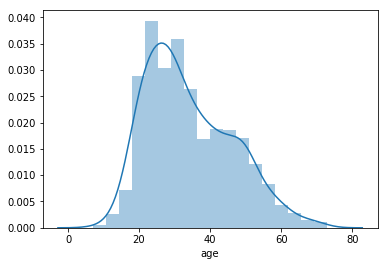

In [7]:
sns.distplot(user_feats['age'])# Histogram of age
plt.show()

In [8]:
# Bining age into categories
bin = [0,18,40,60,80]

category = pd.cut(user_feats['age'],bin ,labels=['child','young','mature','old'])
cat = category.to_frame(name = 'user_ctype')
user_feat = pd.concat([user_feats,cat],axis=1)
user_feat.head()

,user_id,age,sex,occupation,zip_code,user_ctype
0,1,24,M,technician,85711,young
1,2,53,F,other,94043,mature
2,3,23,M,writer,32067,young
3,4,24,M,technician,43537,young
4,5,33,F,other,15213,young


In [9]:
user_feat['sex'].value_counts()

M    670
F    273
Name: sex, dtype: int64

There are 670 male users and 273 female users in the movie lens data.

In [10]:
print(user_feat['occupation'].value_counts().head())
print(user_feats['occupation'].nunique())

student          196
other            105
educator          95
administrator     79
engineer          67
Name: occupation, dtype: int64
21


Maximum users are student in this data and the users belong to 21 different occupations.

As the movie genre data is one hot encoded i.e. the data is in sparse format, no vectorization is required and thus we will simply slice that frame from the complete data and use it further for Content based recommendation.

In [11]:
movie_type = movie_feats[movie_feats.columns[5:24]]
movie_type.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
#Assigning unique indices to movies and dropping the duplicate movies
indices = pd.Series(movie_feats.index, index=movie_feats['title']).drop_duplicates()

In [13]:
#Calculating the cosine similarity between the movie genre using the linear kernel pairwise method
cosine_sim = linear_kernel(movie_type, movie_type)

## Content-Based Recommendation function

In [14]:
# Function for getting the recommendation of the movies on the basis of the movie genre

def get_recommendations(title, cosine_sim=cosine_sim):
    
    ind = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    similarity_scores = list(enumerate(cosine_sim[ind]))

    # Sort the movies based on the similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    similarity_scores = similarity_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in similarity_scores]

    # Return the top 10 most similar movies
    return movie_feats['title'].iloc[movie_indices]

In [15]:
print("The similar recommended movies to From Dusk Till Dawn is:\n", get_recommendations('Evil Dead II (1987)'))

The similar recommended movies to From Dusk Till Dawn is:
 200              Evil Dead II (1987)
16        From Dusk Till Dawn (1996)
20     Muppet Treasure Island (1996)
28             Batman Forever (1995)
100               Heavy Metal (1981)
109      Operation Dumbo Drop (1995)
172       Princess Bride, The (1987)
230            Batman Returns (1992)
256              Men in Black (1997)
384                 True Lies (1994)
Name: title, dtype: object


## Collaborative filtering

In [16]:
data_matrix = np.zeros((n_users, n_movies))
data_matrix.shape

(943, 1682)

In [17]:
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]   

In [18]:
user_sim = pairwise_distances(data_matrix, metric='cosine')
movie_sim = pairwise_distances(data_matrix.T, metric='cosine')

In [19]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [20]:
user_pred = predict(data_matrix, user_sim, type='user')
movie_pred = predict(data_matrix, movie_sim, type='item')

In [21]:
user_pred

array([[ 2.06532606,  0.73430275,  0.62992381, ...,  0.39359041,
         0.39304874,  0.3927712 ],
       [ 1.76308836,  0.38404019,  0.19617889, ..., -0.08837789,
        -0.0869183 , -0.08671183],
       [ 1.79590398,  0.32904733,  0.15882885, ..., -0.13699223,
        -0.13496852, -0.13476488],
       ...,
       [ 1.59151513,  0.27526889,  0.10219534, ..., -0.16735162,
        -0.16657451, -0.16641377],
       [ 1.81036267,  0.40479877,  0.27545013, ..., -0.00907358,
        -0.00846587, -0.00804858],
       [ 1.8384313 ,  0.47964837,  0.38496292, ...,  0.14686675,
         0.14629808,  0.14641455]])

In [22]:
movie_pred

array([[0.44627765, 0.475473  , 0.50593755, ..., 0.58815455, 0.5731069 ,
        0.56669645],
       [0.10854432, 0.13295661, 0.12558851, ..., 0.13445801, 0.13657587,
        0.13711081],
       [0.08568497, 0.09169006, 0.08764343, ..., 0.08465892, 0.08976784,
        0.09084451],
       ...,
       [0.03230047, 0.0450241 , 0.04292449, ..., 0.05302764, 0.0519099 ,
        0.05228033],
       [0.15777917, 0.17409459, 0.18900003, ..., 0.19979296, 0.19739388,
        0.20003117],
       [0.24767207, 0.24489212, 0.28263031, ..., 0.34410424, 0.33051406,
        0.33102478]])

**The shape of predictions from user_similarity matrix and movie similarity matrix is (943 , 1682)**